In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.units import Quantity

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, GCRS, ITRS, Angle, SkyCoord, FK5

In [343]:
from glob import glob

In [341]:
import pandas as pd

In [351]:
from datetime import datetime

In [318]:
import matplotlib.pyplot as plt

In [329]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

In [352]:
# Question I'm trying to answer: does the 02:22:55 UT AARTFAAC observation at apparent Ra:257 Dec:+48 match
#                                the Burlage observation at 02:22:55 at apparent Ra:325, Dec:+49

In [3]:
def radec_to_radec(radec1: SkyCoord, obs1: EarthLocation, obs2: EarthLocation, time: Time, height: Quantity = 100*u.km):
    """
    Convert apparent Ra/Dec from one site to apparent Ra/Dec from another site
    
    Height is the height above the WGS84 ellipsoid.
    
    Note that this assumes a flat Earth, which introduces a small error.
    """
    aa1_far = radec1.transform_to(AltAz(location=obs1, obstime=time))
    aa1_near = AltAz(location=obs1, obstime=time, alt=aa1_far.alt, az=aa1_far.az, distance=height/np.sin(aa1_far.alt))
    aa2_near = aa1_near.transform_to(AltAz(location=obs2, obstime=time))
    aa2_far = AltAz(location=obs2, obstime=time, alt=aa2_near.alt, az=aa2_near.az)
    return aa2_far.transform_to(FK5)

In [4]:
t = Time("2020-08-13T02:22:55", format="isot", scale="utc")

In [5]:
height = 100 * u.km

In [198]:
loc_lofar = EarthLocation(lat = 52.9153 * u.deg,
                          lon = 6.8698 * u.deg,
                          height = 20 * u.m)

loc_dwingeloo = EarthLocation(lat = 52.8344 * u.deg,
                              lon = 6.3785 * u.deg,
                              height = 10 * u.m)

loc_daaro = EarthLocation(
    lat=52.812810 * u.deg, lon=6.396256 * u.deg, height=10 * u.m
)

loc_burlage = EarthLocation(lat = 53.047010 * u.deg,
                            lon = 7.552926 * u.deg,
                            height = 10 * u.m)

In [7]:
radec_to_radec(FK5(ra=257*u.deg, dec=48*u.deg), loc_lofar, loc_burlage, t)

<FK5 Coordinate (equinox=J2000.000): (ra, dec) in deg
    (264.83874058, 38.98317893)>

In [8]:
# Conclusion: the AARTFAAC detection is not the same as the one in Burlage

In [339]:
# Check: radec_to_radec transforms back to the input (errors due to flat earth assumption)
radec_to_radec(radec_to_radec(FK5(ra=257*u.deg, dec=48*u.deg), loc_lofar, loc_burlage, t), loc_burlage, loc_lofar, t)

<FK5 Coordinate (equinox=J2000.000): (ra, dec) in deg
    (257.08523051, 47.91843682)>

In [155]:
camsdata = pd.read_fwf("../cams-matches.txt", index_col=0,
                       header=[0,1], skip_blank_lines=True, skiprows=[2], skipinitialspace=True)

In [160]:
camsdata.columns = [' '.join(col) if isinstance(col, tuple) else col for col in camsdata.columns]

In [161]:
camsdata["astropytime_beg"] = Time(list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])) + np.array(camsdata["Tbeg sec"]) * u.s
camsdata["astropytime_end"] = Time(list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])) + np.array(camsdata["Tend sec"]) * u.s

In [162]:
camsdata.columns

Index(['Observed Date', 'Ref Time UT', 'Tbeg sec', 'Tend sec', 'RAinf deg',
       '+/- sigma', 'DECinf deg', '('+/-', 'sigma').1', 'Vinf km/sec',
       '('+/-', 'sigma').2', 'Acc1 Unnamed: 11_level_1', '('+/-', 'sigma').3',
       'Acc2 Unnamed: 13_level_1', '('+/-', 'sigma').4', 'LatBeg +N deg',
       '('+/-', 'sigma').5', 'LonBeg +E deg', '('+/-', 'sigma').6', 'Hbeg km',
       '('+/-', 'sigma').7', 'LatEnd +N deg', '('+/-', 'sigma').8',
       'LonEnd +E deg', '('+/-', 'sigma').9', 'Hend km', '('+/-', 'sigma').10',
       'Conv deg', 'S-Azim +W deg', 'ZenAng deg', 'Hmax km', 'Max-mV mag',
       'Int-mV mag', 'F-skew Hratio', 'Cameras Contributing',
       'astropytime_beg', 'astropytime_end'],
      dtype='object')

In [353]:
def llh_to_radec(lon, lat, height, obstime, location=loc_daaro):
    """Convert latitude, longitude, height to apparent Ra/Dec at a given site"""
    altaz_near = AltAz(
        az=0 * u.deg,
        alt=90 * u.deg,
        distance=height,
        obstime=obstime,
        location=EarthLocation(lon=lon, lat=lat, height=0),
    ).transform_to(AltAz(location=location, obstime=obstime))

    altaz_far = AltAz(
        location=location, obstime=obstime, alt=altaz_near.alt, az=altaz_near.az
    )

    return altaz_far.transform_to(FK5)

In [354]:
nsteps = 37

In [355]:
uma_starnames = ["Dubhe", "Merak", "Phecda", "Megrez", "Mizar", "Alkaid"]

In [669]:
i = 14

In [670]:
daaro_filename = sorted(glob("../daaro/*.fits"))[i]

In [671]:
daaro_filename

'../daaro/2020-08-13T025739.fits'

In [672]:
daaro_time = Time(datetime.strptime(daaro_filename[-22:-5], "%Y-%m-%dT%H%M%S"))

In [673]:
timediff = np.abs((Time(camsdata['astropytime_beg'].values) - daaro_time).to(u.s))
if np.min(timediff) > 2 * u.s:
    raise Exception("No match")
camsindex = camsdata.iloc[np.argmin(timediff)].name

In [674]:
row = camsdata.loc[camsindex]

In [675]:
row['astropytime_beg'].isot

'2020-08-13T02:57:38.180'

In [676]:
lon = np.linspace(
    row["LonBeg +E deg"] * u.deg, row["LonEnd +E deg"] * u.deg, nsteps
)
lat = np.linspace(
    row["LatBeg +N deg"] * u.deg, row["LatEnd +N deg"] * u.deg, nsteps
)
height = np.linspace(row["Hbeg km"] * u.km, row["Hend km"] * u.km, nsteps)
obstime = Time(
    np.linspace(row["astropytime_beg"].mjd, row["astropytime_end"].mjd, nsteps),
    format="mjd",
)
radec = llh_to_radec(lon, lat, height, obstime)

In [677]:
hdu = fits.open(daaro_filename)[1]

In [678]:
wcs = WCS(hdu.header)

In [679]:
(x, y) = skycoord_to_pixel(radec, wcs, 0)

In [680]:
uma_x = []
uma_y = []
for starname in uma_starnames:
    try:
        starcoord = skycoord_to_pixel(SkyCoord.from_name(starname), wcs, 0)
        uma_x.append(starcoord[0])
        uma_y.append(starcoord[1])
    except:
        pass

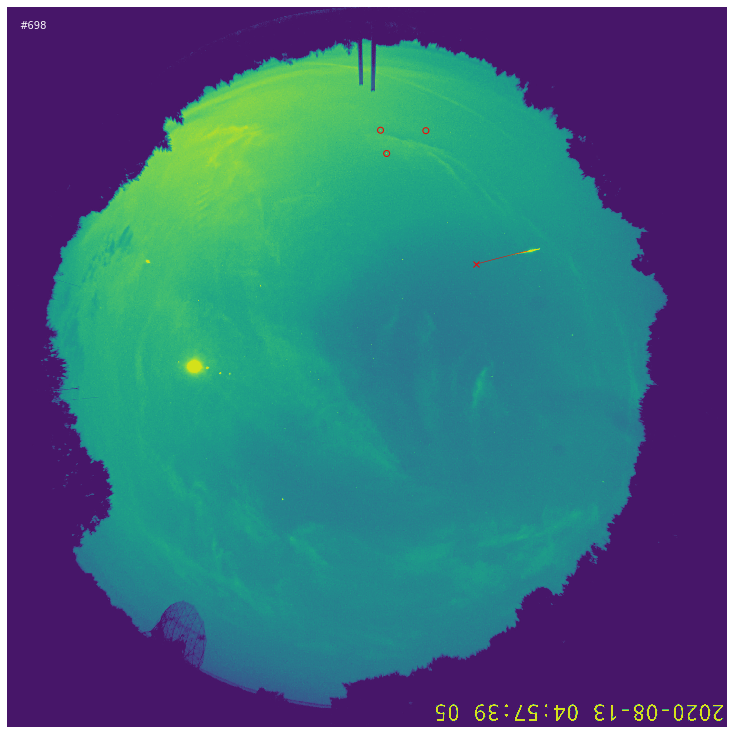

In [682]:
fig = plt.figure(figsize=(10,10))
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(hdu.data, origin='lower');
ax.plot(x, y, color='red', linewidth=0.5);
ax.plot(x[:1], y[:1], 'rx');
ax.set_axis_off()
ax.scatter(uma_x, uma_y, marker='o', color='red', facecolors="None");
ax.text(50, 2900, f'#{camsindex}', color='white');

In [683]:
fig.savefig(daaro_filename.replace(".fits", "-withcams.jpg"))